In [13]:
import lib.Mask2Former as m2f
import lib.Mask2Former.mask2former as mask2former
import os
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from detectron2.engine import (launch)
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.data import build_detection_train_loader
from lib.Mask2Former.train_net import Trainer
import numpy as np
from detectron2.structures import Boxes, Instances, BitMasks, BoxMode
import torch
import torch.nn.functional as F
from detectron2.evaluation import DatasetEvaluator, DatasetEvaluators
from detectron2.data import build_detection_test_loader
from detectron2.utils import comm
from detectron2.structures import BoxMode, pairwise_iou
import copy
import random
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import matplotlib.pyplot as plt
import torchvision.transforms.functional as t_F

In [14]:
DATA_SOURCE = "combined"
DATA_LOCATION = "_data"
DATA_DIR = "coco"
os.environ["DETECTRON2_DATASETS"] = os.path.join(DATA_LOCATION, DATA_DIR)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Convert the dataset to COCO format
The following commands convert the existing PNG mask-based dataset to the coco annotations required for training Mask2Former

In [15]:
#CONFIG = "lib/Mask2Former/configs/coco/instance-segmentation/swin/maskformer2_swin_base_IN21k_384_bs16_50ep.yaml"
CONFIG = "configs/gen_mask2former.yaml"
NUM_GPUS = 1
BATCH_SIZE = 8
LEARNING_RATE = 0.001
DATASET_DIR = "_data/combined/train"
DATASET_DIR_VAL = "_data/combined/val"
IMAGES_DIR_NAME = "images"
IMAGE_DIR = os.path.join(DATASET_DIR, IMAGES_DIR_NAME)
INSTANCES_DIR_NAME = "leaf_instances"
INSTANCES_DIR = os.path.join(DATASET_DIR, INSTANCES_DIR_NAME)
IMAGE_DIR_VAL = os.path.join(DATASET_DIR_VAL, IMAGES_DIR_NAME)
INSTANCES_DIR_VAL = os.path.join(DATASET_DIR_VAL, INSTANCES_DIR_NAME)

# Custom Data Loader

In [16]:
class LeavesDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, file))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_files[index])
        label_path = os.path.join(self.label_dir, self.image_files[index])

        image = Image.open(image_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
            label = self.transform(label).squeeze()

        # Convert label to tensor
        #label = torch.from_numpy(np.array(label))

        # Create instances
        instances = Instances(image.shape[1:])

        # Create gt_boxes
        boxes = []
        gt_classes = []
        gt_masks = []
        unique_labels = torch.unique(label)
        if len(unique_labels) > 1:
            if 255 in unique_labels: 
                print("Invalid label in file", image_path)
            for obj_class in unique_labels:
                if obj_class > 0:
                    mask = label == obj_class
                    coords = torch.nonzero(mask)
                    xmin, ymin = coords.min(dim=0).values
                    xmax, ymax = coords.max(dim=0).values
                    box = [ymin, xmin, ymax, xmax]
                    boxes.append(box)
                    gt_classes.append(1)
                    gt_masks.append(mask)

            instances.gt_boxes = Boxes(torch.tensor(boxes))
            instances.gt_classes = torch.tensor(gt_classes, dtype=torch.long)

            # Resize masks to match the image size
            resized_masks = []
            for mask in gt_masks:
                resized_mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=image.shape[1:], mode='nearest').squeeze().to(torch.bool)
                resized_masks.append(resized_mask)

            if len(resized_masks) > 0:
                instances.gt_masks = torch.stack(resized_masks)
            else:
                print("Masks empty, class lenght is", len(gt_classes))
                instances.gt_masks = torch.Tensor()

            return {
                "image": image,
                "height": image.shape[1],
                "width": image.shape[2],
                "instances": instances,
            }
        
        return {
            "image": image,
            "height": image.shape[1],
            "width": image.shape[2]
        }

In [17]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = t_F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

10589


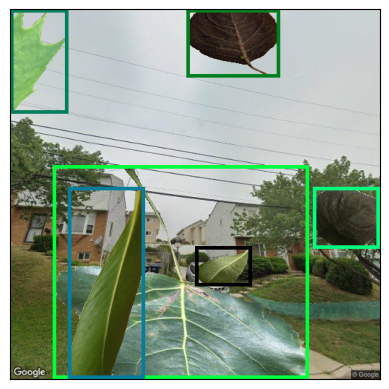

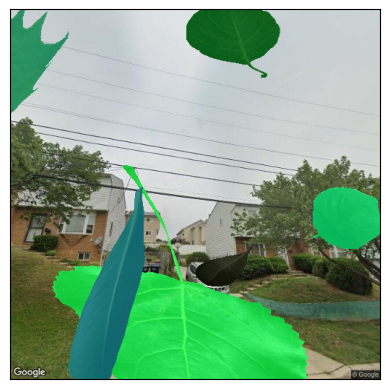

In [18]:
%matplotlib inline
test_ds = LeavesDataset(IMAGE_DIR, INSTANCES_DIR, transforms.Compose([
            transforms.ToTensor(),
        ]))

print(len(test_ds))
sample = test_ds.__getitem__(502)
boxes = sample["instances"].gt_boxes.tensor
result_box = draw_bounding_boxes((sample["image"] * 255).to(torch.uint8), boxes, width=5)
show(result_box)
mask = sample["instances"].gt_masks
result_mask = draw_segmentation_masks(sample["image"], masks=mask, alpha=0.7)
show(result_mask)

In [19]:
class LeavesEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        self.dataset_name = dataset_name
        self._cpu_device = torch.device("cpu")

    def reset(self):
        self._predictions = []
        self._targets = []

    def process(self, inputs, outputs):
        # sample single random instance
#        idx = random.randrange(len(inputs))
#        self._predictions.append(outputs[idx]["instances"].to(self._cpu_device))
#        self._targets.append(inputs[idx]["instances"].to(self._cpu_device))
        for input, output in zip(inputs, outputs):
            self._predictions.append(output["instances"].to(self._cpu_device))
            self._targets.append(input["instances"].to(self._cpu_device))

    def evaluate(self):
        if comm.is_main_process():
            self._evaluate()

        if comm.is_main_process():
            return copy.deepcopy(self._results)
        else:
            return None

    def _evaluate(self):
        self._results = {}
        iou_thresholds = [0.5, 0.75]
        for iou_threshold in iou_thresholds:
            self._results[f"IoU_{iou_threshold}"] = self._compute_iou(iou_threshold)
        #self._results["mask_mse_loss"] = self._compute_mask_mse_loss()
        print(self._results)
        print("First Target:", self._targets[0])
        print("First Prediction", self._predictions[0])

    def _compute_iou(self, iou_threshold):
        print("Computing IoU")
        num_instances = len(self._predictions)
        iou_sum = 0.0

        for pred, target in zip(self._predictions, self._targets):
            pred_boxes = pred.pred_boxes.tensor
            target_boxes = target.gt_boxes.tensor

            if len(pred_boxes) == 0 or len(target_boxes) == 0:
                continue

            # Convert the boxes to the format expected by the pairwise_iou function
            pred_boxes = BoxMode.convert(pred_boxes, BoxMode.XYXY_ABS, BoxMode.XYXY_ABS)
            target_boxes = BoxMode.convert(target_boxes, BoxMode.XYXY_ABS, BoxMode.XYXY_ABS)

            # Compute IoU between predicted and target boxes
            iou_matrix = pairwise_iou(Boxes(pred_boxes), Boxes(target_boxes))
            max_iou, _ = iou_matrix.max(dim=1)

            # Count the number of predicted boxes with IoU above the threshold
            num_above_threshold = (max_iou > iou_threshold).sum().item()
            iou_sum += num_above_threshold

        avg_iou = iou_sum / num_instances
        return avg_iou
    
    def _compute_mask_mse_loss(self):
        print("Computing Mask MSE Loss")
        loss = 0
        for pred, target in zip(self._predictions, self._targets):
            for pred_mask, target_mask in zip(pred.pred_masks, target.gt_masks):
                print("Single MSE")
                target_mask = target_mask.float()
                diff2 = (torch.flatten(pred_mask) - torch.flatten(target_mask)) ** 2.0
                sum2 = 0.0
                num = 0

                flat_mask = torch.flatten(target_mask)
                assert(len(flat_mask) == len(diff2))
                for i in range(len(diff2)):
                    if flat_mask[i] == 1:
                        sum2 += diff2[i]
                        num += 1

                loss += sum2 / num
        return loss


In [20]:
def collate_fn(batch):
    images = []
    instances = []
    extras = {}

    for item in batch:
        images.append(item["image"])
        
        item_instances = item["instances"]
        item_instances["gt_boxes"] = torch.tensor(item_instances["gt_boxes"])
        item_instances["gt_classes"] = torch.tensor(item_instances["gt_classes"], dtype=torch.long)
        item_instances["gt_masks"] = torch.tensor(item_instances["gt_masks"])
        instances.append(item_instances)
        
        extras["height"] = item["height"]
        extras["width"] = item["width"]

    batched_inputs = [
        {"image": image, "instances": instance, **extras}
        for image, instance in zip(images, instances) if instance is not None
    ]

    return batched_inputs

class LeavesTrainer(Trainer):
    @classmethod
    def build_train_loader(cls, _):
        # Define your data transforms
        transform = transforms.Compose([
            transforms.Resize((800, 800)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Create the dataset
        dataset = LeavesDataset(IMAGE_DIR, INSTANCES_DIR, transform=transform, )
        
        # Create the DataLoader
        dataloader = build_detection_train_loader(dataset, mapper=None, total_batch_size=8, num_workers=2)
        return dataloader
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        # Define your data transforms
        transform = transforms.Compose([
            transforms.Resize((800, 800)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Create the dataset
        dataset = LeavesDataset(IMAGE_DIR_VAL, INSTANCES_DIR_VAL, transform=transform, )
        
        # Create the DataLoader
        dataloader = build_detection_test_loader(dataset, mapper=None, num_workers=2)
        return dataloader
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return LeavesEvaluator(dataset_name)

In [21]:
def get_trainer(cfg):
    trainer = LeavesTrainer(cfg)
    #trainer.resume_or_load(resume=args.resume)
    return trainer.train()

In [ ]:
cfg = get_cfg()
add_deeplab_config(cfg)
mask2former.add_maskformer2_config(cfg)
cfg.merge_from_file(CONFIG)

launch(get_trainer, 1, args=(cfg,))

/home/stefan.steinheber/.conda/envs/pytorch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/18 11:26:36 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (

/home/stefan.steinheber/.conda/envs/pytorch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[07/18 11:27:18 d2.utils.events]:  eta: 8 days, 6:19:17  iter: 19  total_loss: 85.18  loss_ce: 2.581  loss_mask: 0.797  loss_dice: 4.9  loss_ce_0: 8.536  loss_mask_0: 0.589  loss_dice_0: 4.775  loss_ce_1: 4.211  loss_mask_1: 0.6778  loss_dice_1: 4.817  loss_ce_2: 2.765  loss_mask_2: 0.6744  loss_dice_2: 4.862  loss_ce_3: 2.27  loss_mask_3: 0.7446  loss_dice_3: 4.901  loss_ce_4: 1.995  loss_mask_4: 0.7618  loss_dice_4: 4.905  loss_ce_5: 2.411  loss_mask_5: 0.7226  loss_dice_5: 4.92  loss_ce_6: 2.074  loss_mask_6: 0.7652  loss_dice_6: 4.916  loss_ce_7: 2.405  loss_mask_7: 0.8307  loss_dice_7: 4.91  loss_ce_8: 2.143  loss_mask_8: 0.9112  loss_dice_8: 4.911    time: 1.9509  last_time: 1.8982  data_time: 0.3935  last_data_time: 0.2806   lr: 1e-05  max_mem: 43765M
[07/18 11:27:57 d2.utils.events]:  eta: 8 days, 5:23:23  iter: 39  total_loss: 74.9  loss_ce: 1.422  loss_mask: 0.8467  loss_dice: 4.902  loss_ce_0: 8.269  loss_mask_0: 0.5152  loss_dice_0: 4.342  loss_ce_1: 1.063  loss_mask_1: 0.6